<a href="https://colab.research.google.com/github/lo-uis/Team_ChoLab/blob/develop/stl_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab.drive
google.colab.drive.mount("gdrive")



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
#!pip install pytorch-lightning

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# **前処理**

In [0]:
class GridMask():
    def __init__(self, p=0.6, d_range=(96, 224), r=0.6):
        self.p = p
        self.d_range = d_range
        self.r = r
        
    def __call__(self, sample):
        """
        sample: torch.Tensor(3, height, width)
        """
        if np.random.uniform() > self.p:
            return sample
        sample = sample.numpy()
        side = sample.shape[1]
        d = np.random.randint(*self.d_range, dtype=np.uint8)
        r = int(self.r * d)
        
        mask = np.ones((side+d, side+d), dtype=np.uint8)
        for i in range(0, side+d, d):
            for j in range(0, side+d, d):
                mask[i: i+(d-r), j: j+(d-r)] = 0
        delta_x, delta_y = np.random.randint(0, d, size=2)
        mask = mask[delta_x: delta_x+side, delta_y: delta_y+side]
        sample *= np.expand_dims(mask, 0)
        return torch.from_numpy(sample)

In [0]:
# tranform tensor
#前処理できる
#trainデータセットの前処理


transform_train = GridMask()
transform_train=transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.RandomHorizontalFlip(), 
    
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #https://teratail.com/questions/234027
    
    ])

In [0]:
#validationデータセットの前処理
transform_val = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) ) #多分正規化
    ])

In [6]:
#load train
#学習に用いて良い画像は、STL10のtrain,unlabeled画像のみとする。
#STL10のテスト画像は、上記の運営賞に用いるので、validationとして用いること
train = torchvision.datasets.STL10(
    root=".", 
    split='train', 
    folds=None,                          #０〜９で選べるぽい
    transform=transform_train,                     #読み込み時の処理
    target_transform=None, 
    download=True)

Extracting ./stl10_binary.tar.gz to .


In [0]:
#データセットの中身を確認
train

Dataset STL10
    Number of datapoints: 5000
    Root location: .
    Split: train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [7]:
#load test for validation
val = torchvision.datasets.STL10(
    root=".", 
    split="test", 
    folds=None,                          
    transform=transform_val,                     
    target_transform=None, 
    download=True)

Files already downloaded and verified


In [0]:
val

Dataset STL10
    Number of datapoints: 8000
    Root location: .
    Split: test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [0]:
train[0][0].shape

torch.Size([3, 224, 224])

In [0]:
#可視化してみる
import numpy as np
import matplotlib.pyplot as plt
img = np.transpose(train[2][0],(1,2,0))
img.shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


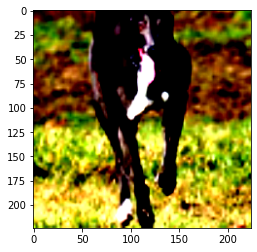

In [0]:
plt.imshow(img)

In [0]:
#type(train[0])

In [0]:
#train[0][0]

In [0]:
#train[1][1]

In [0]:
batch_size = 32

training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False) # testはvaldationとして扱う

classes = ("airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck")

#dataloaders_dict = {"train": train_dataloader, "val": val_dataloader} # 辞書オブジェクトにまとめる

In [0]:
import numpy as np

def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [0]:
(data, target) = iter(training_loader).next()
mixed_data, target_a, target_b, lam = mixup_data(data, target, alpha=1.0, use_cuda=torch.cuda.is_available())

**混同行列**
参考：https://github.com/takoroy/mypytorch-memo

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels):
    import seaborn as sns
    import pandas as pd
    sns.set()
    
    df = pd.DataFrame(cm)
    df.index = labels
    df.columns = labels

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df, annot=True, fmt="d", linewidths=.5, ax=ax)

def validation_confusion_matrix(model):
    images_so_far = 0
    fig = plt.figure()

    all_labels = np.array([])
    all_preds = np.array([])
    for i, data in enumerate(validation_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, labels.cpu().data.numpy())
        all_preds = np.append(all_preds, preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes)

# **DenseNet**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.densenet161(pretrained=use_pretrained).to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [13]:
model.classifier = nn.Linear(in_features=2208, out_features=10, bias=True).to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [15]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する
#https://qiita.com/koshian2/items/4f91ac5cceb6125fd57e

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 再学習するパラメーターを指定する
update_param_names_1 = ["denseblock3"]
update_param_names_2 = ["denseblock4"]
update_param_names_3 = ["classifier.weight", "classifier.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
    
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif update_param_names_2[0] in name:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)
  

勾配計算なし。学習しない： features.conv0.weight
勾配計算なし。学習しない： features.norm0.weight
勾配計算なし。学習しない： features.norm0.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer3.conv1.weight
勾配計算

In [0]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [0]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 1e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [20]:
epochs = 150
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
#save_path = './weights.pth'
#torch.save(model.state_dict(), save_path)

100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


epoch * 1
training loss: 0.0318, training acc 0.7468
validation loss: 0.0142, validation acc0.8823
Validation loss decreased (inf --> 0.014168).  Saving model ...


100%|██████████| 250/250 [00:51<00:00,  4.88it/s]


epoch * 2
training loss: 0.0131, training acc 0.8814
validation loss: 0.0103, validation acc0.8989
Validation loss decreased (0.014168 --> 0.010298).  Saving model ...


100%|██████████| 250/250 [00:51<00:00,  4.90it/s]


epoch * 3
training loss: 0.0115, training acc 0.8872
validation loss: 0.0092, validation acc0.9089
Validation loss decreased (0.010298 --> 0.009236).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.90it/s]


epoch * 4
training loss: 0.0098, training acc 0.9022
validation loss: 0.0088, validation acc0.9085
Validation loss decreased (0.009236 --> 0.008805).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


epoch * 5
training loss: 0.0097, training acc 0.9032
validation loss: 0.0087, validation acc0.9069
Validation loss decreased (0.008805 --> 0.008748).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


epoch * 6
training loss: 0.0092, training acc 0.9022
validation loss: 0.0082, validation acc0.9129
Validation loss decreased (0.008748 --> 0.008177).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


epoch * 7
training loss: 0.0086, training acc 0.9094
validation loss: 0.0077, validation acc0.9186
Validation loss decreased (0.008177 --> 0.007678).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 8
training loss: 0.0080, training acc 0.9166
validation loss: 0.0078, validation acc0.9144
EarlyStopping counter: 1 out of 3


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


epoch * 9
training loss: 0.0081, training acc 0.9102
validation loss: 0.0076, validation acc0.9181
Validation loss decreased (0.007678 --> 0.007632).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


epoch * 10
training loss: 0.0076, training acc 0.9204
validation loss: 0.0073, validation acc0.9195
Validation loss decreased (0.007632 --> 0.007322).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


epoch * 11
training loss: 0.0077, training acc 0.9202
validation loss: 0.0072, validation acc0.9209
Validation loss decreased (0.007322 --> 0.007225).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


epoch * 12
training loss: 0.0075, training acc 0.9222
validation loss: 0.0071, validation acc0.9205
Validation loss decreased (0.007225 --> 0.007113).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


epoch * 13
training loss: 0.0073, training acc 0.9180
validation loss: 0.0071, validation acc0.9216
Validation loss decreased (0.007113 --> 0.007093).  Saving model ...


100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


epoch * 14
training loss: 0.0068, training acc 0.9260
validation loss: 0.0068, validation acc0.9249
Validation loss decreased (0.007093 --> 0.006838).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 15
training loss: 0.0067, training acc 0.9298
validation loss: 0.0070, validation acc0.9229
EarlyStopping counter: 1 out of 3


100%|██████████| 250/250 [00:50<00:00,  4.95it/s]


epoch * 16
training loss: 0.0069, training acc 0.9278
validation loss: 0.0068, validation acc0.9254
Validation loss decreased (0.006838 --> 0.006792).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 17
training loss: 0.0066, training acc 0.9300
validation loss: 0.0071, validation acc0.9218
EarlyStopping counter: 1 out of 3


100%|██████████| 250/250 [00:50<00:00,  4.94it/s]


epoch * 18
training loss: 0.0061, training acc 0.9354
validation loss: 0.0065, validation acc0.9273
Validation loss decreased (0.006792 --> 0.006495).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 19
training loss: 0.0060, training acc 0.9356
validation loss: 0.0071, validation acc0.9233
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 20
training loss: 0.0064, training acc 0.9302
validation loss: 0.0065, validation acc0.9259
EarlyStopping counter: 2 out of 3


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]

epoch * 21
training loss: 0.0064, training acc 0.9302
validation loss: 0.0070, validation acc0.9204
EarlyStopping counter: 3 out of 3
Early stopping


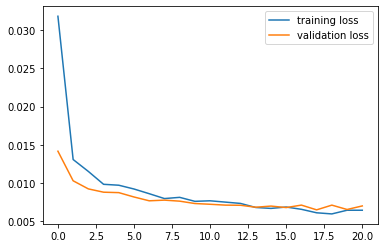

In [21]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

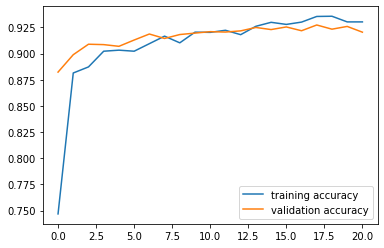

In [22]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 432x288 with 0 Axes>

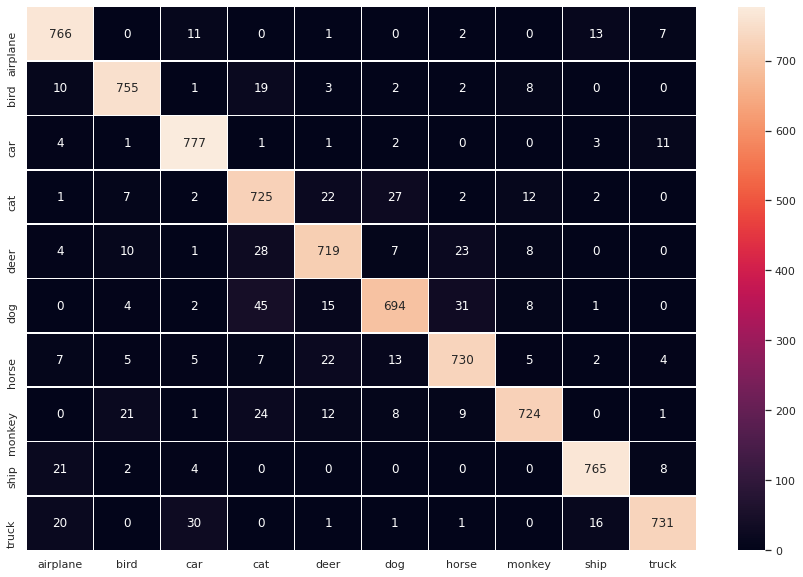

In [23]:
validation_confusion_matrix(model)